In [117]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Function to generate a random binary sequence and count the '1's
def generate_binary_sequence():
    length = random.randint(1, 16)  # Random length between 1 and 16
    sequence = np.random.randint(0, 2, size=length)  # Generate binary sequence
    count_ones = np.sum(sequence)  # Count number of '1's in the sequence
    return sequence.tolist(), count_ones

# Generate 100k sequences with their labels
data = []
for _ in range(100000):
    sequence, count_ones = generate_binary_sequence()
    data.append((sequence, count_ones))

# Split the data into training, validation, and test sets (80%, 10%, 10%)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Example: printing a few examples
print("Examples from the dataset:")
print(f"Training Data (First 3 examples): {train_data[:3]}")
print(f"Validation Data (First 3 examples): {val_data[:3]}")
print(f"Test Data (First 3 examples): {test_data[:3]}")

# Optionally save the data if needed (e.g., in a CSV or a numpy file)
# np.save('train_data.npy', train_data)
# np.save('val_data.npy', val_data)
# np.save('test_data.npy', test_data)


Examples from the dataset:
Training Data (First 3 examples): [([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1], 8), ([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1], 7), ([1], 1)]
Validation Data (First 3 examples): [([0], 0), ([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1], 9), ([0, 1, 1, 1, 1, 0, 1, 0], 5)]
Test Data (First 3 examples): [([0, 0], 0), ([1, 0, 1, 0, 1, 0, 1, 1, 1, 1], 7), ([0], 0)]


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Use the dataset you've generated
def generate_binary_sequence_data(num_sequences=100000):
    data = []
    for _ in range(num_sequences):
        length = np.random.randint(1, 16)  # Random length between 1 and 16
        sequence = np.random.randint(0, 2, size=length)  # Generate binary sequence
        count_ones = np.sum(sequence)  # Count number of '1's in the sequence
        data.append((sequence.tolist(), count_ones))
    return data

# Prepare the data
data = generate_binary_sequence_data()
sequences, labels = zip(*data)

# Find maximum sequence length for padding
max_length = max(len(seq) for seq in sequences)

# Pad sequences to have uniform length
padded_sequences = np.array([seq + [0] * (max_length - len(seq)) for seq in sequences])

labels = np.array(labels)

# Split data into training, validation, and test sets
train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42)
val_sequences, test_sequences, val_labels, test_labels = train_test_split(
    temp_sequences, temp_labels, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
train_data = TensorDataset(torch.tensor(train_sequences, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(val_sequences, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(test_sequences, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

# Model definition
class RNNCountingModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(RNNCountingModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x.unsqueeze(-1))  # Add a dimension for input_size
        out = self.fc(out[:, -1, :])  # Use the last output for prediction
        return out.squeeze(-1)

# Hyperparameters
hidden_size = 128
num_layers = 2
dropout_prob = 0.2
learning_rate =  0.0001
num_epochs = 15

model = RNNCountingModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.L1Loss()  # Mean Absolute Error (MAE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loops
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    correct_count = 0
    total_count = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            y_val_pred = model(x_val)
            val_loss += criterion(y_val_pred, y_val).item()
            
            # Calculate accuracy
            predicted_counts = torch.round(y_val_pred)  # Round to nearest integer
            correct_count += (predicted_counts == y_val).sum().item()
            total_count += y_val.size(0)
            
            # Print the predicted and actual counts for the current batch
            for pred, actual in zip(predicted_counts, y_val):
                print(f"Predicted count: {pred.item()}, Actual count: {actual.item()}")
    
    accuracy = correct_count / total_count * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Validation MAE: {val_loss/len(val_loader):.4f}, Validation Accuracy: {accuracy:.2f}%")


Predicted count: 6.0, Actual count: 6.0
Predicted count: 8.0, Actual count: 8.0
Predicted count: 2.0, Actual count: 2.0
Predicted count: 5.0, Actual count: 5.0
Predicted count: 3.0, Actual count: 3.0
Predicted count: 5.0, Actual count: 5.0
Predicted count: 1.0, Actual count: 1.0
Predicted count: 5.0, Actual count: 5.0
Predicted count: 2.0, Actual count: 2.0
Predicted count: 1.0, Actual count: 1.0
Predicted count: 1.0, Actual count: 1.0
Predicted count: 8.0, Actual count: 8.0
Predicted count: 4.0, Actual count: 4.0
Predicted count: 9.0, Actual count: 10.0
Predicted count: 3.0, Actual count: 3.0
Predicted count: 3.0, Actual count: 3.0
Predicted count: 5.0, Actual count: 5.0
Predicted count: 4.0, Actual count: 4.0
Predicted count: 6.0, Actual count: 6.0
Predicted count: 7.0, Actual count: 7.0
Predicted count: 8.0, Actual count: 8.0
Predicted count: 2.0, Actual count: 2.0
Predicted count: 5.0, Actual count: 5.0
Predicted count: 7.0, Actual count: 7.0
Predicted count: 1.0, Actual count: 1.0

Sequence Length: 1, MAE: 2.0704
Sequence Length: 2, MAE: 5.0074
Sequence Length: 3, MAE: 6.9305
Sequence Length: 4, MAE: 6.6755
Sequence Length: 5, MAE: 5.8558
Sequence Length: 6, MAE: 5.0915
Sequence Length: 7, MAE: 4.4157
Sequence Length: 8, MAE: 3.8065
Sequence Length: 9, MAE: 3.2313
Sequence Length: 10, MAE: 2.6692
Sequence Length: 11, MAE: 2.1169
Sequence Length: 12, MAE: 1.5679
Sequence Length: 13, MAE: 1.0276
Sequence Length: 14, MAE: 0.4894
Sequence Length: 15, MAE: 0.0622
Sequence Length: 16, MAE: 0.6056
Sequence Length: 17, MAE: 1.1318
Sequence Length: 18, MAE: 1.6790
Sequence Length: 19, MAE: 2.2039
Sequence Length: 20, MAE: 2.7556
Sequence Length: 21, MAE: 3.2976
Sequence Length: 22, MAE: 3.8132
Sequence Length: 23, MAE: 4.3586
Sequence Length: 24, MAE: 4.8889
Sequence Length: 25, MAE: 5.4211
Sequence Length: 26, MAE: 5.9669
Sequence Length: 27, MAE: 6.5168
Sequence Length: 28, MAE: 7.0135
Sequence Length: 29, MAE: 7.5399
Sequence Length: 30, MAE: 8.0890
Sequence Length: 31

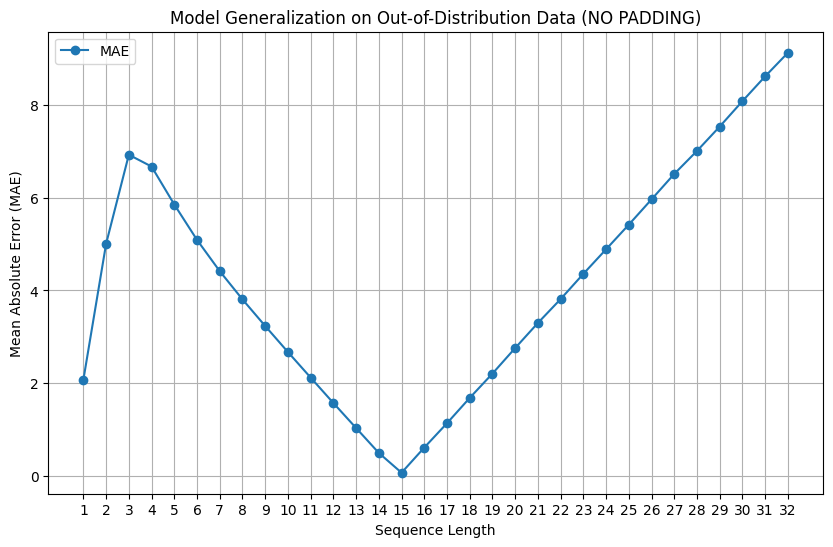

Sequence Length: 1, MAE: 0.5015
Sequence Length: 2, MAE: 0.5317
Sequence Length: 3, MAE: 0.5516
Sequence Length: 4, MAE: 0.5662
Sequence Length: 5, MAE: 0.5718
Sequence Length: 6, MAE: 0.5757
Sequence Length: 7, MAE: 0.5766
Sequence Length: 8, MAE: 0.5751
Sequence Length: 9, MAE: 0.5726
Sequence Length: 10, MAE: 0.5735
Sequence Length: 11, MAE: 0.5729
Sequence Length: 12, MAE: 0.5722
Sequence Length: 13, MAE: 0.5714
Sequence Length: 14, MAE: 0.5712
Sequence Length: 15, MAE: 0.5781
Sequence Length: 16, MAE: 0.5989
Sequence Length: 17, MAE: 1.1345
Sequence Length: 18, MAE: 1.6731
Sequence Length: 19, MAE: 2.2095
Sequence Length: 20, MAE: 2.7556
Sequence Length: 21, MAE: 3.2777
Sequence Length: 22, MAE: 3.8165
Sequence Length: 23, MAE: 4.3521
Sequence Length: 24, MAE: 4.8984
Sequence Length: 25, MAE: 5.4408
Sequence Length: 26, MAE: 5.9726
Sequence Length: 27, MAE: 6.4962
Sequence Length: 28, MAE: 7.0410
Sequence Length: 29, MAE: 7.5601
Sequence Length: 30, MAE: 8.1059
Sequence Length: 31

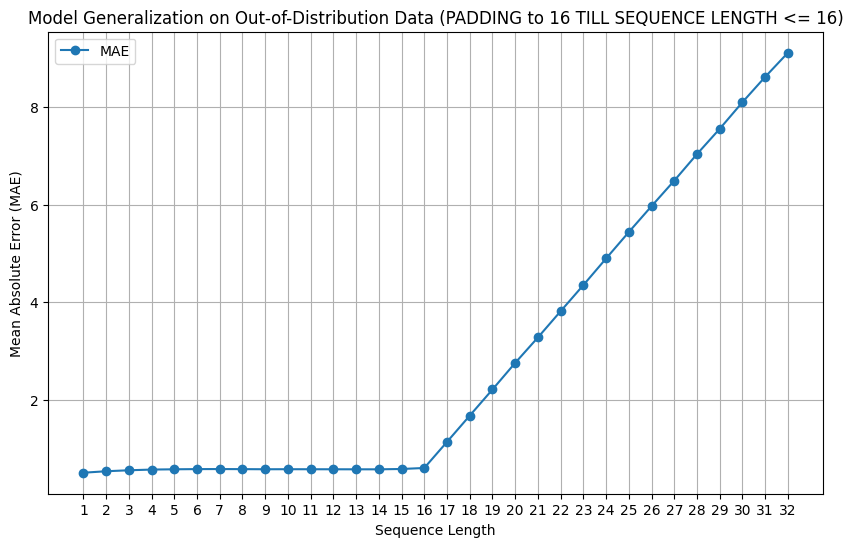

Sequence Length: 1, MAE: 11.5466
Sequence Length: 2, MAE: 11.9157
Sequence Length: 3, MAE: 12.0914
Sequence Length: 4, MAE: 11.9183
Sequence Length: 5, MAE: 11.6287
Sequence Length: 6, MAE: 11.1580
Sequence Length: 7, MAE: 10.5543
Sequence Length: 8, MAE: 10.0621
Sequence Length: 9, MAE: 9.6749
Sequence Length: 10, MAE: 9.3914
Sequence Length: 11, MAE: 9.1971
Sequence Length: 12, MAE: 8.9934
Sequence Length: 13, MAE: 8.9348
Sequence Length: 14, MAE: 8.9384
Sequence Length: 15, MAE: 8.9548
Sequence Length: 16, MAE: 8.9858
Sequence Length: 17, MAE: 9.0193
Sequence Length: 18, MAE: 9.0472
Sequence Length: 19, MAE: 9.0829
Sequence Length: 20, MAE: 9.0946
Sequence Length: 21, MAE: 9.0947
Sequence Length: 22, MAE: 9.1177
Sequence Length: 23, MAE: 9.1192
Sequence Length: 24, MAE: 9.1177
Sequence Length: 25, MAE: 9.1331
Sequence Length: 26, MAE: 9.1278
Sequence Length: 27, MAE: 9.1101
Sequence Length: 28, MAE: 9.1245
Sequence Length: 29, MAE: 9.1041
Sequence Length: 30, MAE: 9.1169
Sequence Le

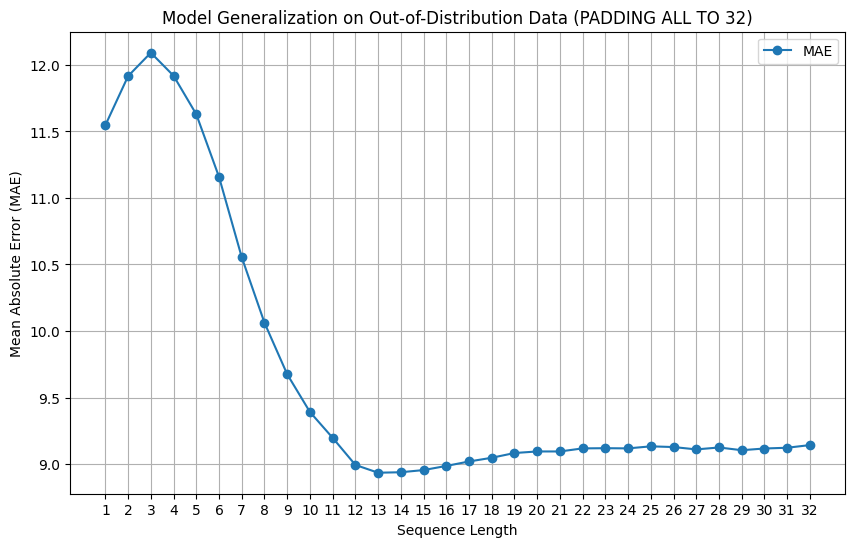

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Function to generate binary sequence data for specific lengths
def generate_sequence_data_for_length(sequence_length, num_samples=1000):
    sequences = []
    labels = []
    for _ in range(num_samples):
        sequence = np.random.randint(0, 2, size=sequence_length)  # Generate binary sequence
        count_ones = np.sum(sequence)  # Count number of '1's
        sequences.append(sequence)
        labels.append(count_ones)
    return np.array(sequences), np.array(labels)

# Evaluate model on OOD data
sequence_lengths = range(1, 33)  # Sequence lengths from 1 to 32
mae_per_length = []
criterion = nn.L1Loss()  # Define the criterion

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for length in sequence_lengths:
        sequences, labels = generate_sequence_data_for_length(sequence_length=length, num_samples=1000)

        # Conditional padding: pad up to 16 for sequences <= 16, no padding for others
        if length <= 0:
            padded_sequences = np.array([list(seq) + [0] * (16 - len(seq)) for seq in sequences])
        else:
            padded_sequences = np.array(sequences)  # Use sequences as-is for lengths > 16

        # Convert to tensors
        padded_sequences = torch.tensor(padded_sequences, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)

        # Model predictions
        predictions = model(padded_sequences)
        mae = criterion(predictions, labels).item()  # Compute MAE
        mae_per_length.append(mae)

        print(f"Sequence Length: {length}, MAE: {mae:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, mae_per_length, marker='o', label='MAE')
plt.title("Model Generalization on Out-of-Distribution Data (NO PADDING)")
plt.xlabel("Sequence Length")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(sequence_lengths)
plt.grid(True)
plt.legend()
plt.show()


# Function to generate binary sequence data for specific lengths
def generate_sequence_data_for_length(sequence_length, num_samples=1000):
    sequences = []
    labels = []
    for _ in range(num_samples):
        sequence = np.random.randint(0, 2, size=sequence_length)  # Generate binary sequence
        count_ones = np.sum(sequence)  # Count number of '1's
        sequences.append(sequence)
        labels.append(count_ones)
    return np.array(sequences), np.array(labels)

# Evaluate model on OOD data
sequence_lengths = range(1, 33)  # Sequence lengths from 1 to 32
mae_per_length = []
criterion = nn.L1Loss()  # Define the criterion


model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for length in sequence_lengths:
        sequences, labels = generate_sequence_data_for_length(sequence_length=length, num_samples=1000)

        # Conditional padding: pad up to 16 for sequences <= 16, no padding for others
        if length <= 16:
            padded_sequences = np.array([list(seq) + [0] * (16 - len(seq)) for seq in sequences])
        else:
            padded_sequences = np.array(sequences)  # Use sequences as-is for lengths > 16

        # Convert to tensors
        padded_sequences = torch.tensor(padded_sequences, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)

        # Model predictions
        predictions = model(padded_sequences)
        mae = criterion(predictions, labels).item()  # Compute MAE
        mae_per_length.append(mae)

        print(f"Sequence Length: {length}, MAE: {mae:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, mae_per_length, marker='o', label='MAE')
plt.title("Model Generalization on Out-of-Distribution Data (PADDING to 16 TILL SEQUENCE LENGTH <= 16)")
plt.xlabel("Sequence Length")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(sequence_lengths)
plt.grid(True)
plt.legend()
plt.show()




# Function to generate binary sequence data for specific lengths
def generate_sequence_data_for_length(sequence_length, num_samples=1000):
    sequences = []
    labels = []
    for _ in range(num_samples):
        sequence = np.random.randint(0, 2, size=sequence_length)  # Generate binary sequence
        count_ones = np.sum(sequence)  # Count number of '1's
        sequences.append(sequence)
        labels.append(count_ones)
    return np.array(sequences), np.array(labels)

# Evaluate model on OOD data
sequence_lengths = range(1, 33)  # Sequence lengths from 1 to 32
mae_per_length = []
criterion = nn.L1Loss()  # Define the criterion


model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for length in sequence_lengths:
        sequences, labels = generate_sequence_data_for_length(sequence_length=length, num_samples=1000)

        # Conditional padding: pad up to 16 for sequences <= 16, no padding for others
        if length <= 32:
            padded_sequences = np.array([list(seq) + [0] * (32 - len(seq)) for seq in sequences])
        else:
            padded_sequences = np.array(sequences)  # Use sequences as-is for lengths > 16

        # Convert to tensors
        padded_sequences = torch.tensor(padded_sequences, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)

        # Model predictions
        predictions = model(padded_sequences)
        mae = criterion(predictions, labels).item()  # Compute MAE
        mae_per_length.append(mae)

        print(f"Sequence Length: {length}, MAE: {mae:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, mae_per_length, marker='o', label='MAE')
plt.title("Model Generalization on Out-of-Distribution Data (PADDING ALL TO 32)")
plt.xlabel("Sequence Length")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(sequence_lengths)
plt.grid(True)
plt.legend()
plt.show()

